In [1]:
import time

time.sleep(10800)

In [2]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

import sys
n_external = 3001

zmin = 3.5
zmax = 8.1

chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_'
oup_fname +='zmin_%.5f_zmax_%.5f_quad_next_%d.npy'%(zmin, 
                                                    zmax, 
                                                    n_external)
print(oup_fname)

/scratch/users/delon/LIMxCMBL/IHiKappa/Ik_zmin_3.50000_zmax_8.10000_quad_next_3001.npy


In [3]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

In [4]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_Kkappa = get_f_Kkappa()

In [5]:
_KI = np.array(KI)

In [6]:
from interpax import interp2d, interp1d
import jax.numpy as jnp
from jax import jit

In [7]:
inner_dkparp_integral = np.load('/oak/stanford/orgs/kipac/users/delon/LIMxCMBL/inner_dkparp_integral.npy')
inner_dkparp_integral = inner_dkparp_integral.astype(np.float64)

from scipy.interpolate import interp1d, interp2d, LinearNDInterpolator

tmp_chibs = []
tmp_log_deltas = []
tmp_fnctn = []
for i in range(len(chibs)):
    for j in range(len(deltas)):
        tmp_chibs += [chibs[i]]
        tmp_log_deltas += [np.log(deltas[j])]
        tmp_fnctn += [inner_dkparp_integral[:,i,j]]
        
f_inner_integral = LinearNDInterpolator(list(zip(tmp_chibs, tmp_log_deltas)), tmp_fnctn)

In [8]:
import matplotlib.pyplot as plt

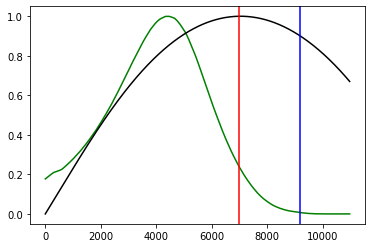

In [9]:
plt.plot(chis, _KI/np.max(_KI), 'g')
plt.plot(chis, Wk * Dz/np.max(Wk * Dz), 'k')

plt.axvline(chimin, c='r')
plt.axvline(chimax, c='b')

In [10]:
external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)

In [11]:
chimax-chimin

2209.5380240233635

In [12]:
def integrand(chib):
    _delta = np.abs(1 - external_chis / chib)
    _delta = np.where(_delta < 1e-6, 1e-6,
                     np.where(_delta > 0.7, 
                             0.7,
                             _delta))    
    return np.einsum('x,x,xl->lx',
                     2 * np.interp(x = external_chis, xp = chis, fp = _KI, left = 0, right = 0),
                     np.interp(x = 2*chib - external_chis, xp = chis, fp = Wk * Dz, left = 0, right = 0),
                     f_inner_integral((chib, np.log(_delta)))) / chib**2

In [13]:
integrand(8080).shape

(100, 3001)

In [14]:
chis

array([0.00000000e+00, 1.09697762e+00, 2.19395523e+00, ...,
       1.09664852e+04, 1.09675822e+04, 1.09686792e+04])

In [15]:
from scipy.integrate import quad_vec, dblquad, nquad


In [16]:
I_kappa, _ = quad_vec(integrand, 10, chimax_sample,
                      limit = 11234567,
                      epsabs = 0.0,
                      epsrel=1e-3,
                     workers=32)

In [17]:
I_kappa.shape

(100, 3001)

In [18]:
np.max(np.abs(I_kappa))

1.1373669935071544e-07

In [19]:
np.save(oup_fname, I_kappa)

In [20]:
n_bins = 100
chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
dchi_binned = np.mean(np.diff(chi_bin_edges))

In [21]:
def get_binned(base, n_external = 300):
    external_chis = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_external)
#     print('external chi spacing', np.mean(np.diff(external_chis)))
    
    oup = np.zeros((100, n_bins), dtype=np.float64)
    for i, (l1, r1) in enumerate(zip(chi_bin_edges, chi_bin_edges[1:])):
            idx1 = np.where((external_chis > l1) & (external_chis <= r1))[0]
            oup[:,i] = (np.sum(base[:,idx1[0]:idx1[-1]+1,], 
                                 axis=(1)) / len(idx1))
    return oup

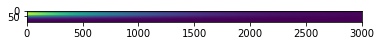

In [22]:
plt.imshow(I_kappa)

In [23]:
I_kappa_binned = get_binned(I_kappa, n_external = n_external)

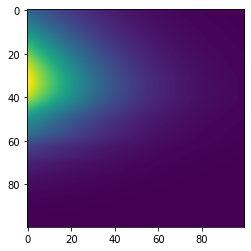

In [24]:
plt.imshow(I_kappa_binned)